In [24]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import Resize
import matplotlib.pyplot as plt
import torch

class MultitaskDataset(Dataset):
    def __init__(self, root_dir, annotation_file,
                 transform=None,
                 rgb=True,
                 depth=False,
                 pose=False,
                 depth_folder='depth_poses',
                 rgb_folder='salient_poses',
                 pose_csv='salient_landmarks.csv',
                 target_size=(360, 640)):
        """
        Args:
            root_dir (string): Directory with 'depth' and 'rgb' folders.
            annotation_file (string): Path to the annotations CSV file.
            transform (callable, optional): Optional transform to be applied
                on the frames (both depth and RGB).
            depth_folder (string): Folder containing depth data.
            rgb_folder (string): Folder containing RGB data.
            target_size (tuple): Target size for resizing the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.resize_transform = Resize(target_size)
        self.depth = depth
        self.rgb = rgb
        self.pose = pose
        
        # Load the annotation file and extract the video names
        self.annotation_df = pd.read_csv(annotation_file)
        self.allowed_video_names = self.annotation_df['name'].unique()

        # List of tuples: (depth_frame_path, rgb_frame_path, class_label)
        self.frame_paths = []

        # Create a list of all video folders and corresponding class labels
        if self.depth: 
            self.depth_dir = os.path.join(root_dir, depth_folder)
        if self.rgb:
            self.rgb_dir = os.path.join(root_dir, rgb_folder)

        if self.pose:
            self.pose_dir = os.path.join(root_dir, pose_csv)
            self.pose_df = pd.read_csv(self.pose_dir)
            
            # Read the poses and store them in a dictionary
            self.pose_dict = self.load_pose_dict(self.pose_df)

        # Iterate over the video folders and extract frame paths
        for class_name in os.listdir(self.depth_dir if self.depth else self.rgb_dir):
            if self.depth:
                class_depth_path = os.path.join(self.depth_dir, class_name)
            if self.rgb:
                class_rgb_path = os.path.join(self.rgb_dir, class_name)

            if (self.depth and os.path.isdir(class_depth_path)) or (self.rgb and os.path.isdir(class_rgb_path)):
                for video_name in os.listdir(class_depth_path if self.depth else class_rgb_path):
                    if video_name in self.allowed_video_names:
                        if self.depth:
                            video_depth_path = os.path.join(class_depth_path, video_name)
                            depth_frames = sorted([os.path.join(video_depth_path, fname) 
                                                   for fname in os.listdir(video_depth_path) 
                                                   if fname.endswith('.pfm')])
                        if self.rgb:
                            video_rgb_path = os.path.join(class_rgb_path, video_name)
                            rgb_frames = sorted([os.path.join(video_rgb_path, fname) 
                                                 for fname in os.listdir(video_rgb_path)])
                        
                        # Ensure the same number of frames
                        if self.depth and self.rgb and len(depth_frames) != len(rgb_frames):
                            continue  # Skip misaligned frames

                        if self.depth and self.rgb:
                            frame_pairs = zip(depth_frames, rgb_frames)
                        elif self.depth:
                            frame_pairs = zip(depth_frames, [None] * len(depth_frames))
                        elif self.rgb:
                            frame_pairs = zip([None] * len(rgb_frames), rgb_frames)

                        for depth_frame, rgb_frame in frame_pairs:
                            pose_key = os.path.join(class_name, video_name, os.path.basename(rgb_frame) if rgb_frame else '')
                            self.frame_paths.append((depth_frame, rgb_frame, pose_key, class_name))

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        result = dict()

        # Load paths and label for the specific frame
        depth_frame_path, rgb_frame_path, pose_key, label = self.frame_paths[idx]

        if self.depth:
            # Load depth frame (assuming .pfm format for depth)
            depth_frame, _ = self.read_pfm(depth_frame_path)
            depth_frame = self.scale_depth(depth_frame)

            # Add a channel dimension to the depth frame (1 channel for grayscale)
            depth_frame = torch.tensor(np.copy(depth_frame)).unsqueeze(0)  # Shape will be (1, H, W)

            # Resize depth frame to the target size
            depth_frame_resized = self.resize_transform(depth_frame)
            
            result['depth'] = depth_frame_resized

        if self.rgb and rgb_frame_path:
            # Load RGB frame
            rgb_frame = Image.open(rgb_frame_path)

            # Resize RGB frame to the target size
            rgb_frame_resized = self.resize_transform(rgb_frame)

            # Apply any other transformations if necessary
            if self.transform:
                rgb_frame_resized = self.transform(rgb_frame_resized)

            result['rgb'] = rgb_frame_resized

        if self.pose:
            result['pose'] = self.pose_dict[pose_key]

        result['label'] = label

        return result

    def read_pfm(self, filename):
        """Read a PFM file and return the image data and scale factor."""
        with open(filename, 'rb') as f:
            header = f.readline().decode('latin1').rstrip()
            if header not in ('PF', 'Pf'):
                raise ValueError('Not a PFM file.')
            color = header == 'PF'
            
            # Read dimensions
            dims_line = f.readline().decode('latin1').rstrip()
            width, height = map(int, dims_line.split())
            
            # Read scale
            scale = float(f.readline().decode('latin1').rstrip())
            big_endian = scale > 0
            if not big_endian:
                scale = -scale
                
            # Read the pixel data
            num_channels = 3 if color else 1
            data = np.fromfile(f, '<f' if not big_endian else '>f', count=width * height * num_channels)
            data = np.reshape(data, (height, width, num_channels))
            
            # Flip the image vertically to correct the orientation
            data = np.flipud(data)  

            return data, scale

    def scale_depth(self, depth_frame):
        # Squeeze depth data and replace NaN or inf values
        depth_data_squeezed = np.squeeze(depth_frame)  
        depth_data_cleaned = np.nan_to_num(depth_data_squeezed, nan=0.0, posinf=0.0, neginf=0.0)

        # Apply Min-Max Scaling
        min_val = np.nanmin(depth_data_cleaned)
        max_val = np.nanmax(depth_data_cleaned)
        return (depth_data_cleaned - min_val) / (max_val - min_val)

    def visualize_depth(self, idx):
         # Load depth frame for visualization
        depth_frame_path, _, _, _ = self.frame_paths[idx]
        depth_frame, _ = self.read_pfm(depth_frame_path)
        depth_frame = self.scale_depth(depth_frame) * 255  

        # Convert to uint8 and visualize
        depth_data_uint8 = np.clip(depth_frame, 0, 255).astype(np.uint8) 
        plt.imshow(depth_data_uint8, cmap='gray')  
        plt.title('Min-Max Scaled Depth Image')
        plt.axis('off')
        plt.show()

    def scale_and_clip(self, df):
        # Scale x and y columns (divide by image size and clip)
        x_columns = df.columns[df.columns.str.endswith('_x')]
        df[x_columns] = df[x_columns].div(640).clip(lower=0, upper=1)

        y_columns = df.columns[df.columns.str.endswith('_y')]
        df[y_columns] = df[y_columns].div(360).clip(lower=0, upper=1)

        return df

    def load_pose_dict(self, df):
        df = self.scale_and_clip(df)
        df['video_name'] = df['scorer'].apply(lambda x: x.split('/')[-2])  
        df['frame_name'] = df['scorer'].apply(lambda x: x.split('/')[-1])  
        df['class'] = df['scorer'].apply(lambda x: x.split('/')[-3])  

        # Filter rows by allowed video names
        filtered_df = df[df['video_name'].isin(self.allowed_video_names)]
        filtered_df = filtered_df.drop(columns=['scorer'])

        # Create pose landmarks dictionary
        pose_landmarks_dict = {}
        pose_columns = filtered_df.columns[1:-2]  

        for _, row in filtered_df.iterrows():
            key = f"{row['class']}/{row['video_name']}/{row['frame_name']}"
            landmarks = torch.tensor(row[pose_columns].values.astype(float), dtype=torch.float)
            pose_landmarks_dict[key] = landmarks

        return pose_landmarks_dict


# Example usage:
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Assuming your dataset is located at '../../data/BiteCount'
dataset = MultitaskDataset(annotation_file='./bitecount_poserac.csv',
                           root_dir='../../data/BiteCount',
                           transform=transform,
                           rgb=True,
                           depth=False)


In [25]:
idx = 100

In [26]:
dataset.frame_paths[idx]

(None,
 '../../data/BiteCount/salient_poses/salient1/549a581a8eb4d9e66844c0409c97091b8dd6dd632607739d780cfd503bffbac0.mp4/5.jpg',
 'salient1/549a581a8eb4d9e66844c0409c97091b8dd6dd632607739d780cfd503bffbac0.mp4/5.jpg',
 'salient1')

In [28]:
dataset.__getitem__(idx)

{'rgb': tensor([[[0.1176, 0.1216, 0.1333,  ..., 0.2471, 0.2510, 0.2275],
          [0.1294, 0.1333, 0.1373,  ..., 0.2549, 0.2627, 0.2353],
          [0.1255, 0.1255, 0.1137,  ..., 0.2627, 0.2706, 0.2549],
          ...,
          [0.3373, 0.3333, 0.3294,  ..., 0.2863, 0.2824, 0.2706],
          [0.3373, 0.3333, 0.3294,  ..., 0.2902, 0.2863, 0.2824],
          [0.2980, 0.3020, 0.3137,  ..., 0.2902, 0.2941, 0.2941]],
 
         [[0.1176, 0.1216, 0.1333,  ..., 0.2471, 0.2510, 0.2275],
          [0.1294, 0.1333, 0.1373,  ..., 0.2549, 0.2627, 0.2353],
          [0.1255, 0.1255, 0.1137,  ..., 0.2627, 0.2706, 0.2549],
          ...,
          [0.3373, 0.3333, 0.3294,  ..., 0.2863, 0.2824, 0.2706],
          [0.3373, 0.3333, 0.3294,  ..., 0.2902, 0.2863, 0.2824],
          [0.2980, 0.3020, 0.3137,  ..., 0.2902, 0.2941, 0.2941]],
 
         [[0.1176, 0.1216, 0.1333,  ..., 0.2471, 0.2510, 0.2275],
          [0.1294, 0.1333, 0.1373,  ..., 0.2549, 0.2627, 0.2353],
          [0.1255, 0.1255, 0.1137

In [36]:
dataset.__getitem__(idx)['pose']

tensor([0.5160, 1.0000, 0.6055, 1.0000, 0.5802, 1.0000, 0.5577, 0.6534, 0.5524,
        0.8131, 0.3707, 1.0000, 0.5957, 1.0000, 0.5626, 1.0000, 0.5214, 0.9114,
        0.5667, 0.8732, 0.4699, 0.8615, 0.4167, 0.8798, 0.4558, 0.6800, 0.3826,
        0.8726, 0.3586, 0.7218, 0.4150, 0.7202, 0.4098, 0.7070, 0.4175, 0.7158,
        0.4158, 0.4146, 0.4423, 0.7749, 0.4424, 0.7927, 0.4446, 0.7904, 0.4395,
        0.7651, 0.3917, 0.7887, 0.4233, 0.7671, 0.4087, 0.6063, 0.4425, 0.5929,
        0.3334, 0.7835, 0.1908, 0.4545, 0.1937, 0.9833, 0.1978, 0.4232, 0.2034,
        0.3546, 0.1899, 0.8095, 0.4566, 0.9796, 0.4578, 0.9870, 0.4564, 0.9793,
        0.4519, 0.9694])

In [37]:
landmarks = dataset.__getitem__(idx)['pose'].view(-1, 2)
landmarks

tensor([[0.5160, 1.0000],
        [0.6055, 1.0000],
        [0.5802, 1.0000],
        [0.5577, 0.6534],
        [0.5524, 0.8131],
        [0.3707, 1.0000],
        [0.5957, 1.0000],
        [0.5626, 1.0000],
        [0.5214, 0.9114],
        [0.5667, 0.8732],
        [0.4699, 0.8615],
        [0.4167, 0.8798],
        [0.4558, 0.6800],
        [0.3826, 0.8726],
        [0.3586, 0.7218],
        [0.4150, 0.7202],
        [0.4098, 0.7070],
        [0.4175, 0.7158],
        [0.4158, 0.4146],
        [0.4423, 0.7749],
        [0.4424, 0.7927],
        [0.4446, 0.7904],
        [0.4395, 0.7651],
        [0.3917, 0.7887],
        [0.4233, 0.7671],
        [0.4087, 0.6063],
        [0.4425, 0.5929],
        [0.3334, 0.7835],
        [0.1908, 0.4545],
        [0.1937, 0.9833],
        [0.1978, 0.4232],
        [0.2034, 0.3546],
        [0.1899, 0.8095],
        [0.4566, 0.9796],
        [0.4578, 0.9870],
        [0.4564, 0.9793],
        [0.4519, 0.9694]])

In [38]:
# Reshape the flattened landmarks into (N, 2) where N is the number of points
landmarks = dataset.__getitem__(idx)['pose'].view(-1, 2)

# Convert RGB tensor to a format suitable for plotting
image = dataset.__getitem__(idx)['rgb'].permute(1, 2, 0).numpy()  # Change to HWC format
image = (image * 255).astype('uint8')  # Scale to 0-255

# Create a plot
plt.imshow(image)
plt.axis('off')  # Turn off axis

# Plot landmarks
for (x, y) in landmarks:
    plt.scatter(y * image.shape[0], x * image.shape[1], color='red', s=100, marker='o')

plt.show()

KeyError: 'pose'

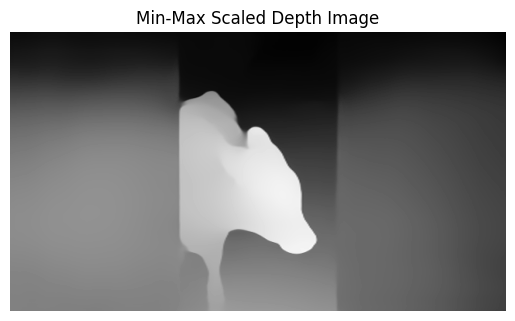

In [39]:
dataset.visualize_depth(idx)